In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


In [ ]:
def ConstructHists(E_reco,Nbins=50):
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges
# 打开 ROOT 文件，载入 events tree
DataPath="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
ParticleEnergy=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
hist_E = []
hist_N = []
E_sum = []
N_hits = []
E_true = []
for i_E in range(len(ParticleEnergy)):
    input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    Event_energy = [np.sum(e) * 1000 for e in energy]
    Number_hits = [len(e) for e in energy]
    E_sum.extend(Event_energy)
    N_hits.extend(Number_hits)
    E_true.extend([ParticleEnergy[i_E]]*len(Event_energy))

for i_E in range(len(ParticleEnergy)):
    
    #Sum of E
    counts, bin_edges = ConstructHists(np.array(Event_energy))
    hist = {
        'counts': counts,
        'bin_edges': bin_edges,
        'Energy': ParticleEnergy[i_E]
        }
    hist_E.append(hist)
    #Number of hits
    Number_hits = np.array(Number_hits)
    N_bins = min(50, (Number_hits.max() - Number_hits.min()))
    counts, bin_edges = ConstructHists(Number_hits, Nbins=N_bins)
    hist = {
        'counts': counts,
        'bin_edges': bin_edges,
        'Energy': ParticleEnergy[i_E]
        }
    hist_N.append(hist)



Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_la

In [3]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(E, type, bin_edges, counts):    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')
    if type == "E":
        plt.title(f"Deposited Energy {E} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = max(bin_edges[0], mean - k*theta) # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-100, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]


    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / mean_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * mean_gamma - np.sqrt(k) * theta * (theta)) / (mean_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (mean_gamma**2)
    dr_dtheta = (np.sqrt(k) * mean_gamma - np.sqrt(k) * theta * (k - 1.0)) / (mean_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")

    #Gaussian Fit
    params_gauss_initial = np.array([max(counts), res_gamma, peak_gamma])
    lower_bounds = 0.5 * params_gauss_initial
    upper_bounds = 100 * params_gauss_initial
    print(f"Initial Gaussian Fit Parameters: {params_gauss_initial}")
    params_gauss, cov_gauss = curve_fit(fit_gaussian, bin_centers, counts, p0=params_gauss_initial, bounds=(lower_bounds, upper_bounds))
    peak_gauss = peak_gamma
    sigma_gauss = res_gamma * peak_gamma
    fit_mask = (bin_centers >= peak_gauss - 2 * sigma_gauss) & (bin_centers <= peak_gauss + 2 * sigma_gauss)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]
    params_gauss, cov_gauss = curve_fit(fit_gaussian, x_fit, y_fit, p0=params_gauss_initial)
    x_fit_gauss = x_fit
    y_fit_gauss = fit_gaussian(x_fit, *params_gauss)
    peak_gauss = params_gauss[2]
    peak_gauss_error = np.sqrt(cov_gauss[2, 2])
    mean_gauss = peak_gauss
    mean_gauss_error = peak_gauss_error
    res_gauss = params_gauss[1]
    res_gauss_error = np.sqrt(cov_gauss[1, 1])
    print(f"Gaussian Fit Peak: {peak_gauss} ± {peak_gauss_error}, Resolution: {res_gauss} ± {res_gauss_error}")

    #Log Normal Fit
    var = rms**2
    sigma = np.sqrt(np.log(var/(mean**2)+1))
    scale = np.sqrt( var / ( np.exp(sigma**2) * (np.exp(sigma**2) - 1)) )
    loc = max(peak - scale*np.exp(-sigma**2), 0.1)
    params_log_normal_initial = np.array([max(counts), sigma, loc, scale])
    lower_bounds = 0.001 * params_log_normal_initial
    upper_bounds = 1000 * params_log_normal_initial
    print(f"Initial Log Normal Fit Parameters: {params_log_normal_initial}")
    params_log_normal, cov_log_normal = curve_fit(fit_log_normal, bin_centers, counts, p0=params_log_normal_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Log Normal Fit Parameters: {params_log_normal}")
    x_fit_log_normal = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_log_normal = fit_log_normal(x_fit_log_normal, *params_log_normal)
    sigma, loc, scale = params_log_normal[1], params_log_normal[2], params_log_normal[3]
    peak_log_normal=loc + scale * np.exp(-sigma**2)
    mean_log_normal = loc + scale * np.exp(sigma**2 / 2)
    var = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2)
    res_log_normal = np.sqrt(var) / mean_log_normal    
    # ---- error propagation ----
    # partial derivatives for peak
    d_peak_d_sigma = -2 * sigma * scale * np.exp(-sigma**2)
    d_peak_d_loc = 1.0
    d_peak_d_scale = np.exp(-sigma**2)    
    # partial derivatives for variance
    d_var_d_sigma = (2*sigma*np.exp(sigma**2) * np.exp(2*np.log(scale) + sigma**2)
                     + (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * 2*sigma)
    d_var_d_scale = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * (2/scale)
    # derivatives for resolution
    d_res_d_sigma = (0.5 / np.sqrt(var) * d_var_d_sigma * peak - np.sqrt(var) * d_peak_d_sigma) / (peak**2)
    d_res_d_loc = -np.sqrt(var) * d_peak_d_loc / (peak**2)
    d_res_d_scale = (0.5 / np.sqrt(var) * d_var_d_scale * peak - np.sqrt(var) * d_peak_d_scale) / (peak**2)
    # errors
    peak_grad = np.array([0, d_peak_d_sigma, d_peak_d_loc, d_peak_d_scale])
    mean_grad = np.array([0, d_peak_d_sigma/2, d_peak_d_loc, d_peak_d_scale])  
    res_grad  = np.array([0, d_res_d_sigma, d_res_d_loc, d_res_d_scale])    
    peak_log_normal_error = np.sqrt(peak_grad @ cov_log_normal @ peak_grad)
    mean_log_normal_error = np.sqrt(mean_grad @ cov_log_normal @ mean_grad)
    res_log_normal_error  = np.sqrt(res_grad @ cov_log_normal @ res_grad)
    print(f"Log Normal Fit Peak: {peak_log_normal} ± {peak_log_normal_error}, Resolution: {res_log_normal} ± {res_log_normal_error}")

    plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")
    plt.plot(x_fit_gamma, y_fit_gamma, 'g-', label="Gamma Fit")
    plt.plot(x_fit_log_normal, y_fit_log_normal, 'm-', label="Log Normal Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
            mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
            mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error)



<>:130: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3525831/1137045438.py:130: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")


Mean: 768.4912680983782, Peak: 774.78369140625, RMS: 23.43045358562015
Initial Gamma Fit Parameters: [np.float64(22159.350952148438), np.float64(4.939323369183992), np.float32(652.7607), np.float64(23.43045358562015)]
Gamma Fit Parameters: [2.21485227e+04 4.93932337e+01 6.05766657e+02 3.32483214e+00]
Gamma Fit Peak: 769.9908675605744 ± 0.44110012608845944, Resolution: 0.030347147779170844 ± 0.0003884093740786607
Initial Gaussian Fit Parameters: [3.92000000e+02 3.03471478e-02 7.66666035e+02]
Gaussian Fit Peak: 768.3136152726001 ± 0.3898387298470333, Resolution: 0.0302799273174562 ± 0.0005511318382189813
Initial Log Normal Fit Parameters: [3.92000000e+02 3.04818184e-02 7.36273269e+00 7.68134333e+02]
Log Normal Fit Parameters: [2.21469299e+04 3.01542801e-02 6.39287615e-02 7.68445402e+02]
Log Normal Fit Peak: 767.8109160530798 ± 0.37805795889342836, Resolution: 0.030158628263817946 ± 0.0003134595500055942


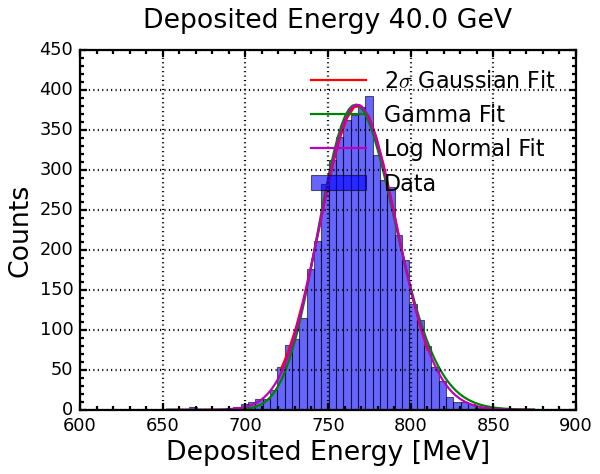

In [4]:
#This cell is left here for debug
hist = hist_E[9]
(mean_gauss,mean_gauss_error,peak_gauss,peak_gauss_error,res_gauss,res_gauss_error,
 mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error,
 mean_log_normal,mean_log_normal_error,peak_log_normal,peak_log_normal_error,res_log_normal,res_log_normal_error) = fit_all(hist['Energy'],"E", hist['bin_edges'], hist['counts'])




Mean: 1.93157323504614, Peak: 1.3072490692138672, RMS: 1.1281353439978623
Initial Gamma Fit Parameters: [np.float64(767.8934695273638), np.float64(1.7121821821494143), np.float32(0.0), np.float64(1.1281353439978623)]
Gamma Fit Parameters: [7.56764646e+02 2.74631377e+00 1.41111323e-01 6.41131904e-01]
Gamma Fit Peak: 1.901860699846332 ± 0.023370484765474042, Resolution: 0.5586550921054386 ± 0.016107143447418922
Initial Gaussian Fit Parameters: [364.           0.55865509   1.2607288 ]
Gaussian Fit Peak: 1.4708072851571454 ± 0.047532179550099474, Resolution: 0.520003061291382 ± 0.039462038029999084
Initial Log Normal Fit Parameters: [3.64000000e+02 5.41757243e-01 1.00000000e-01 1.66793171e+00]
Log Normal Fit Parameters: [7.82478082e+02 6.14710097e-01 1.00000000e-04 1.74146461e+00]
Log Normal Fit Peak: 1.193561591517538 ± 0.02117734684112272, Resolution: 0.6775894057550499 ± 0.07398245360792138


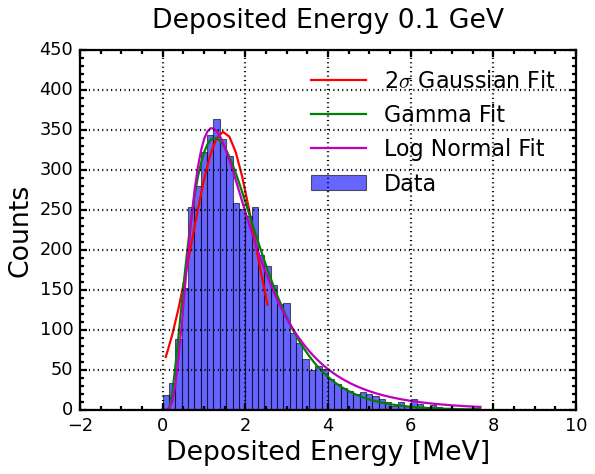

Mean: 4.79832430764305, Peak: 4.020348072052002, RMS: 1.776288001485409
Initial Gamma Fit Parameters: [np.float64(1295.8489944934845), np.float64(2.701321127897325), np.float32(0.0), np.float64(1.776288001485409)]
Gamma Fit Parameters: [1.29521003e+03 5.10040775e+00 7.96261407e-01 7.88278987e-01]
Gamma Fit Peak: 4.8168056620487665 ± 0.04550699735664054, Resolution: 0.3695926054527108 ± 0.010381411298347933
Initial Gaussian Fit Parameters: [356.           0.36959261   4.02852668]
Gaussian Fit Peak: 4.363535846484133 ± 0.07171284008525225, Resolution: 0.3556016421537422 ± 0.018681744182118758
Initial Log Normal Fit Parameters: [3.56000000e+02 3.58369161e-01 1.00000000e-01 4.49988809e+00]
Log Normal Fit Parameters: [1.31068711e+03 3.81356558e-01 1.00000000e-04 4.58558191e+00]
Log Normal Fit Peak: 3.965014092729675 ± 0.04284529154160273, Resolution: 0.3956433900991297 ± 0.021446856312810913


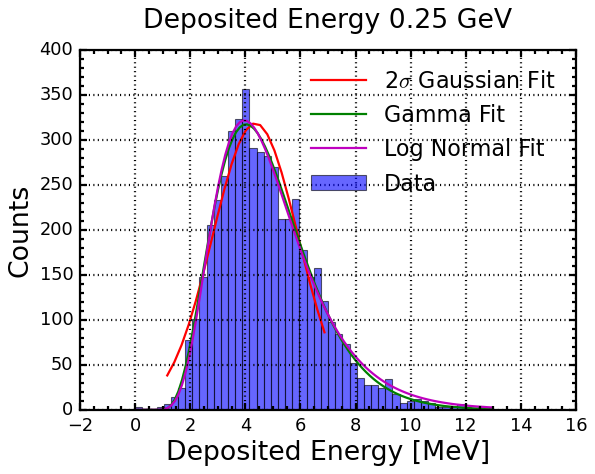

Mean: 9.621792049235106, Peak: 8.038276672363281, RMS: 2.5341096885106444
Initial Gamma Fit Parameters: [np.float64(2004.3489336967468), np.float64(3.709577739062381), np.float32(0.22131516), np.float64(2.5341096885106444)]
Gamma Fit Parameters: [1.99800926e+03 1.10959316e+01 1.24355234e+00 7.57171230e-01]
Gamma Fit Peak: 9.645072492755004 ± 0.04894338149877188, Resolution: 0.26149927710886234 ± 0.0045971278059356
Initial Gaussian Fit Parameters: [3.28000000e+02 2.61499277e-01 8.88790126e+00]
Gaussian Fit Peak: 9.206705297657521 ± 0.0691750800377173, Resolution: 0.2561989918180297 ± 0.008384355448608063
Initial Log Normal Fit Parameters: [3.28000000e+02 2.58968704e-01 1.00000000e-01 9.30449983e+00]
Log Normal Fit Parameters: [2.00969802e+03 2.66058320e-01 1.00000000e-04 9.43269962e+00]
Log Normal Fit Peak: 8.788171632508002 ± 0.04964749845812488, Resolution: 0.27083409660875923 ± 0.008376201787554886


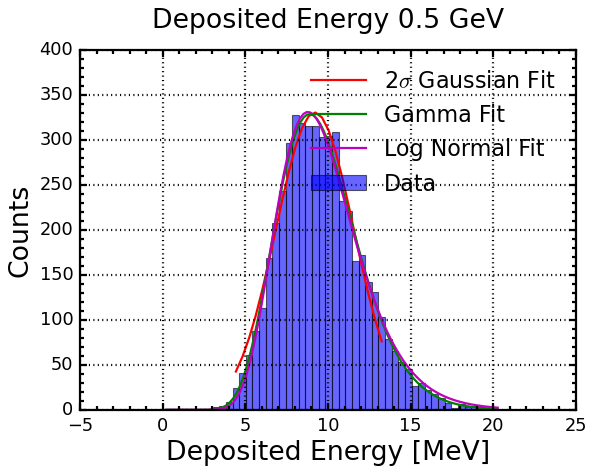

Mean: 19.21644379115386, Peak: 18.30594825744629, RMS: 3.6271042459986904
Initial Gamma Fit Parameters: [np.float64(2805.9257860183716), np.float64(3.113917916044021), np.float32(7.921939), np.float64(3.6271042459986904)]
Gamma Fit Parameters: [2.80281405e+03 1.56510772e+01 4.88565620e+00 9.17048904e-01]
Gamma Fit Peak: 19.23845940669574 ± 0.07961922008524878, Resolution: 0.18857943140149533 ± 0.0034067114012747805
Initial Gaussian Fit Parameters: [3.51000000e+02 1.88579431e-01 1.83214105e+01]
Gaussian Fit Peak: 18.72516840914516 ± 0.09841835637174497, Resolution: 0.18559214099606894 ± 0.005741358772268681
Initial Log Normal Fit Parameters: [3.51000000e+02 1.87100580e-01 1.00000000e-01 1.88830189e+01]
Log Normal Fit Parameters: [2.81102464e+03 1.89619077e-01 1.00000004e-04 1.89496711e+01]
Log Normal Fit Peak: 18.280531710496383 ± 0.07726136206966469, Resolution: 0.1913353793738625 ± 0.004269730690809897


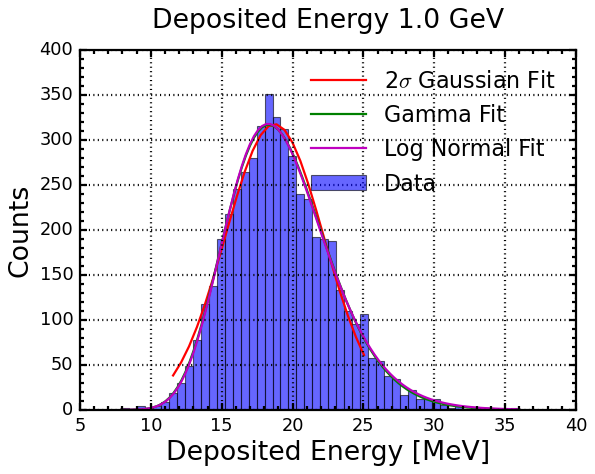

Mean: 38.41351950073242, Peak: 36.857177734375, RMS: 5.094166707287801
Initial Gamma Fit Parameters: [np.float64(4094.3336486816406), np.float64(3.118571082117794), np.float32(22.526999), np.float64(5.094166707287801)]
Gamma Fit Parameters: [4.09390705e+03 3.11857108e+01 9.95859003e+00 9.15812752e-01]
Gamma Fit Peak: 38.51886166517785 ± 0.10510534669336133, Resolution: 0.1327733967273386 ± 0.0020095843306314554
Initial Gaussian Fit Parameters: [3.35000000e+02 1.32773397e-01 3.76030489e+01]
Gaussian Fit Peak: 38.01892153222172 ± 0.10583321574113769, Resolution: 0.13205863844420987 ± 0.0030142417358801545
Initial Log Normal Fit Parameters: [3.35000000e+02 1.32036339e-01 1.00000000e-01 3.80801318e+01]
Log Normal Fit Parameters: [4.09673457e+03 1.32946061e-01 1.00000001e-04 3.82300319e+01]
Log Normal Fit Peak: 37.560365615769264 ± 0.1049973468258164, Resolution: 0.13353532798374998 ± 0.002367168120850517


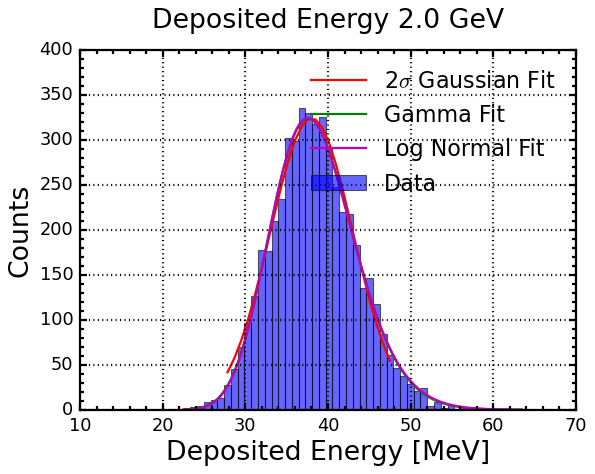

Mean: 96.19424800407224, Peak: 93.69734954833984, RMS: 8.04638037243716
Initial Gamma Fit Parameters: [np.float64(6432.133758544922), np.float64(3.4291573051732662), np.float32(68.601944), np.float64(8.04638037243716)]
Gamma Fit Parameters: [6.48406097e+03 3.42915731e+01 4.78081904e+01 1.41771551e+00]
Gamma Fit Peak: 96.42388523120016 ± 0.20654185437583236, Resolution: 0.08609901178820224 ± 0.0015265752631382897
Initial Gaussian Fit Parameters: [3.43000000e+02 8.60990118e-02 9.50061697e+01]
Gaussian Fit Peak: 95.67265418623313 ± 0.20221422962156532, Resolution: 0.08555013639611832 ± 0.0023180523370260847
Initial Log Normal Fit Parameters: [3.43000000e+02 8.35014441e-02 1.00000000e-01 9.58594751e+01]
Log Normal Fit Parameters: [6.48411930e+03 8.94962102e-02 3.97897123e+00 9.19242696e+01]
Log Normal Fit Peak: 95.16990758357677 ± 0.2028937348071724, Resolution: 0.08596937719344645 ± 0.0015692549111512258


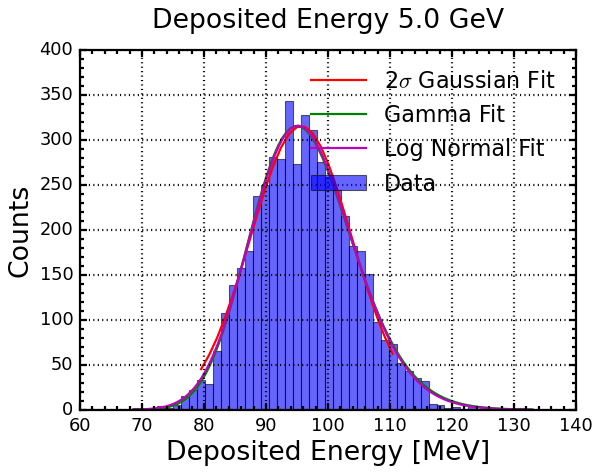

Mean: 192.39743844620367, Peak: 193.37646484375, RMS: 11.47152661670307
Initial Gamma Fit Parameters: [np.float64(9424.329345703125), np.float64(4.434923565061021), np.float32(141.5221), np.float64(11.47152661670307)]
Gamma Fit Parameters: [9.38383470e+03 4.43492357e+01 1.17400627e+02 1.70565623e+00]
Gamma Fit Peak: 193.04517738975971 ± 0.1818524090389122, Resolution: 0.05884040019694205 ± 0.0006502849803776697
Initial Gaussian Fit Parameters: [3.45000000e+02 5.88404002e-02 1.91339521e+02]
Gaussian Fit Peak: 192.12588967657356 ± 0.11190068811890623, Resolution: 0.05787914369296936 ± 0.0006289018051556269
Initial Log Normal Fit Parameters: [3.45000000e+02 5.95712234e-02 2.00045543e+00 1.92056358e+02]
Log Normal Fit Parameters: [9.37616238e+03 5.84547914e-02 2.00045545e-03 1.92348858e+02]
Log Normal Fit Peak: 191.69473150584872 ± 0.1422781217718757, Resolution: 0.05850415398623588 ± 0.0004951255752405814


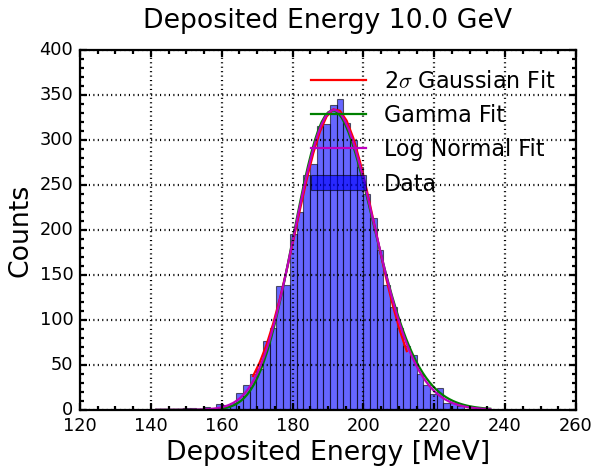

Mean: 384.390203306444, Peak: 387.39996337890625, RMS: 16.202830734638855
Initial Gamma Fit Parameters: [np.float64(13572.50732421875), np.float64(3.4190595433491406), np.float32(328.99176), np.float64(16.202830734638855)]
Gamma Fit Parameters: [1.35207706e+04 3.41905954e+01 2.91130226e+02 2.75596694e+00]
Gamma Fit Peak: 385.35837714121703 ± 0.3281353780469715, Resolution: 0.041817929991356376 ± 0.0005947739946288873
Initial Gaussian Fit Parameters: [3.5900000e+02 4.1817930e-02 3.8260241e+02]
Gaussian Fit Peak: 383.93679340202897 ± 0.2481572915141851, Resolution: 0.041129593441561786 ± 0.0006925815204630642
Initial Log Normal Fit Parameters: [3.59000000e+02 4.21333328e-02 4.03196295e+00 3.84049167e+02]
Log Normal Fit Parameters: [1.35109476e+04 4.13975666e-02 4.03196567e-03 3.84130521e+02]
Log Normal Fit Peak: 383.4768097176192 ± 0.2695426382697719, Resolution: 0.041414874931724514 ± 0.0004543731799067143


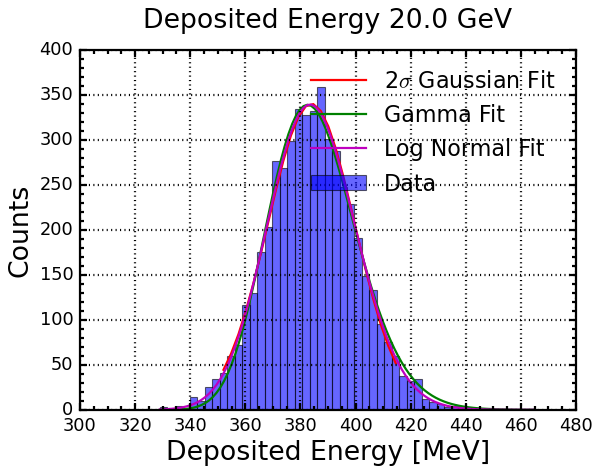

Mean: 576.6333100617708, Peak: 570.36279296875, RMS: 20.2517839387481
Initial Gamma Fit Parameters: [np.float64(17855.35675048828), np.float64(4.987161178155039), np.float32(475.6344), np.float64(20.2517839387481)]
Gamma Fit Parameters: [1.78089617e+04 4.98716118e+01 4.35867337e+02 2.85119483e+00]
Gamma Fit Peak: 578.0610190621142 ± 0.5612361905780472, Resolution: 0.03483212037680949 ± 0.0006588995171553636
Initial Gaussian Fit Parameters: [3.67000000e+02 3.48321204e-02 5.75209824e+02]
Gaussian Fit Peak: 576.6408383118944 ± 0.4838443880818767, Resolution: 0.03467568393717797 ± 0.0009186797559968926
Initial Log Normal Fit Parameters: [3.67000000e+02 3.51099092e-02 1.00000000e-01 5.76278010e+02]
Log Normal Fit Parameters: [1.78041516e+04 3.45864349e-02 1.02739934e-04 5.76803787e+02]
Log Normal Fit Peak: 576.1143168535933 ± 0.4973748935889159, Resolution: 0.034596774602580434 ± 0.0005640554661845957


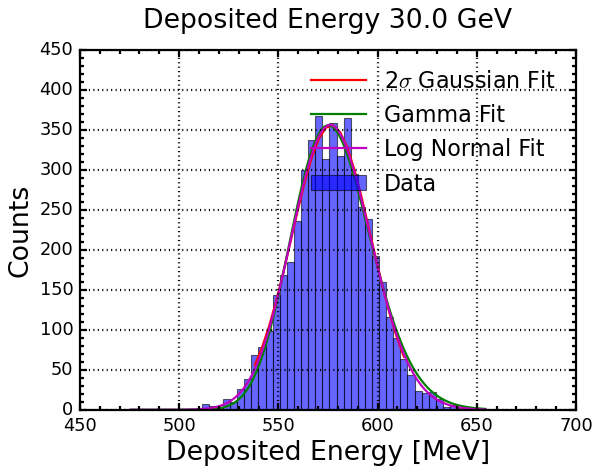

Mean: 768.4912680983782, Peak: 774.78369140625, RMS: 23.43045358562015
Initial Gamma Fit Parameters: [np.float64(22159.350952148438), np.float64(4.939323369183992), np.float32(652.7607), np.float64(23.43045358562015)]
Gamma Fit Parameters: [2.21485227e+04 4.93932337e+01 6.05766657e+02 3.32483214e+00]
Gamma Fit Peak: 769.9908675605744 ± 0.44110012608845944, Resolution: 0.030347147779170844 ± 0.0003884093740786607
Initial Gaussian Fit Parameters: [3.92000000e+02 3.03471478e-02 7.66666035e+02]
Gaussian Fit Peak: 768.3136152726001 ± 0.3898387298470333, Resolution: 0.0302799273174562 ± 0.0005511318382189813
Initial Log Normal Fit Parameters: [3.92000000e+02 3.04818184e-02 7.36273269e+00 7.68134333e+02]
Log Normal Fit Parameters: [2.21469299e+04 3.01542801e-02 6.39287615e-02 7.68445402e+02]
Log Normal Fit Peak: 767.8109160530798 ± 0.37805795889342836, Resolution: 0.030158628263817946 ± 0.0003134595500055942


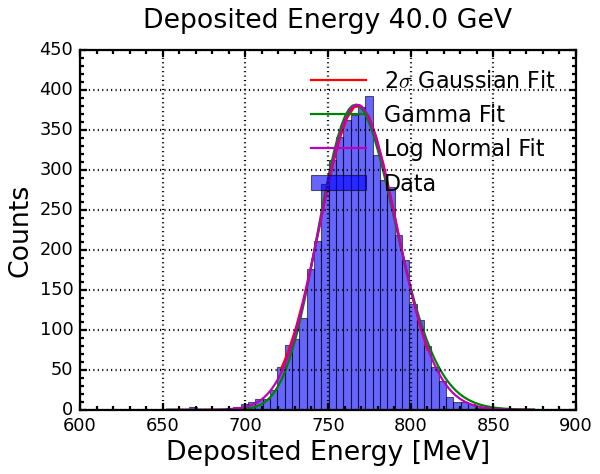

Mean: 960.9601508558547, Peak: 963.5045776367188, RMS: 26.152627000139134
Initial Gamma Fit Parameters: [np.float64(21701.28631591797), np.float64(4.633496566068825), np.float32(839.78204), np.float64(26.152627000139134)]
Gamma Fit Parameters: [2.16092981e+04 4.63349657e+01 7.86283495e+02 3.81167155e+00]
Gamma Fit Peak: 962.8971650540173 ± 0.6361585542409905, Resolution: 0.026945731951365477 ± 0.0004489607484030631
Initial Gaussian Fit Parameters: [3.45000000e+02 2.69457320e-02 9.59085494e+02]
Gaussian Fit Peak: 960.96060181753 ± 0.5162987416551762, Resolution: 0.026660060460973776 ± 0.0005909366293289423
Initial Log Normal Fit Parameters: [3.45000000e+02 2.72100631e-02 3.61105876e+00 9.60604475e+02]
Log Normal Fit Parameters: [2.15966161e+04 2.67076053e-02 3.61105880e-03 9.61137667e+02]
Log Normal Fit Peak: 960.4559469023744 ± 0.5355646309320256, Resolution: 0.026712268339786707 ± 0.0003554837491670432


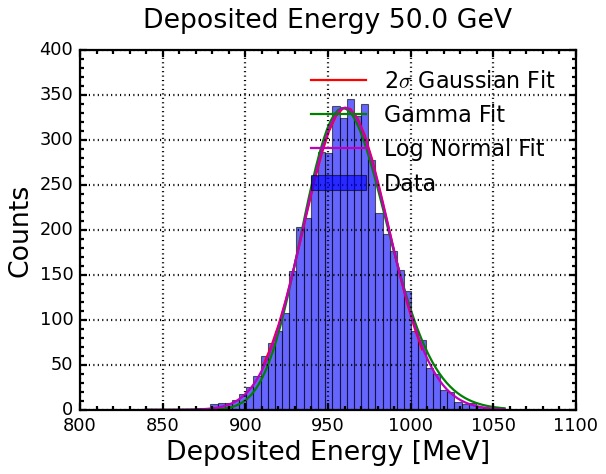

Mean: 1152.1699506031744, Peak: 1152.0123291015625, RMS: 29.334692499508776
Initial Gamma Fit Parameters: [np.float64(27338.628479003906), np.float64(4.947683076642478), np.float32(1007.0312), np.float64(29.334692499508776)]
Gamma Fit Parameters: [2.72582231e+04 4.94768308e+01 9.49505297e+02 4.14056750e+00]
Gamma Fit Peak: 1154.3674547347264 ± 0.6449975033520149, Resolution: 0.025229969853268707 ± 0.0003780901152030086
Initial Gaussian Fit Parameters: [3.98000000e+02 2.52299699e-02 1.15022689e+03]
Gaussian Fit Peak: 1152.3057265807688 ± 0.5263160346315292, Resolution: 0.025098942477047425 ± 0.0004976418188976296
Initial Log Normal Fit Parameters: [3.98000000e+02 2.54562621e-02 9.61780333e-01 1.15179670e+03]
Log Normal Fit Parameters: [2.72561214e+04 2.50428035e-02 5.61726337e-03 1.15245951e+03]
Log Normal Fit Peak: 1151.7425938600702 ± 0.5220686208657193, Resolution: 0.025046608321862243 ± 0.0002900410305206279


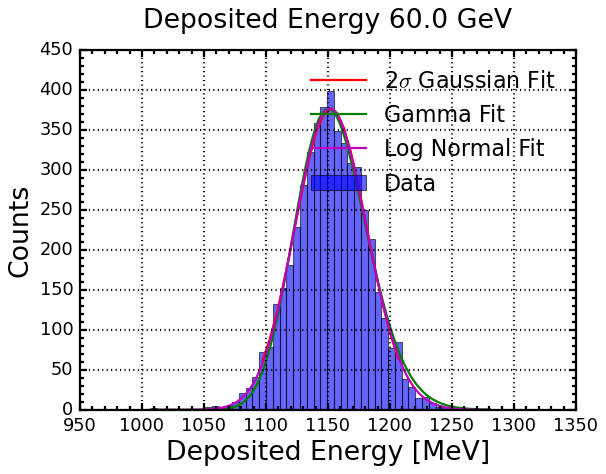

In [5]:
#Fit Sum of E and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    hist = hist_E[i_E]
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(hist['Energy'],"E", hist['bin_edges'], hist['counts'])
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, "SumE_Fit.csv")
df.to_csv(outputfile_name, index=False)



Mean: 4.919370540774823, Peak: 4.2, RMS: 1.72819024381888
Initial Gamma Fit Parameters: [np.float64(4665.733333333334), np.float64(2.846544562075649), np.float64(0.0), np.float64(1.72819024381888)]
Gamma Fit Parameters: [ 4.64831255e+03  1.07391479e+01 -6.55309543e-01  5.18792272e-01]
Gamma Fit Peak: 4.916077401104463 ± 0.015901551172313046, Resolution: 0.34582763781139403 ± 0.0031063020646674034
Initial Gaussian Fit Parameters: [1.13300000e+03 3.45827638e-01 4.39728513e+00]
Gaussian Fit Peak: 4.618166361070424 ± 0.07799771049281304, Resolution: 0.33934030259400705 ± 0.018650160022979534
Initial Log Normal Fit Parameters: [1.13300000e+03 3.41133642e-01 1.00000000e-01 4.64130002e+00]
Log Normal Fit Parameters: [4.69652046e+03 3.60725983e-01 1.00000000e-04 4.81355562e+00]
Log Normal Fit Peak: 4.2263403471603045 ± 0.0688951505050947, Resolution: 0.37277784998062485 ± 0.03075234949411082


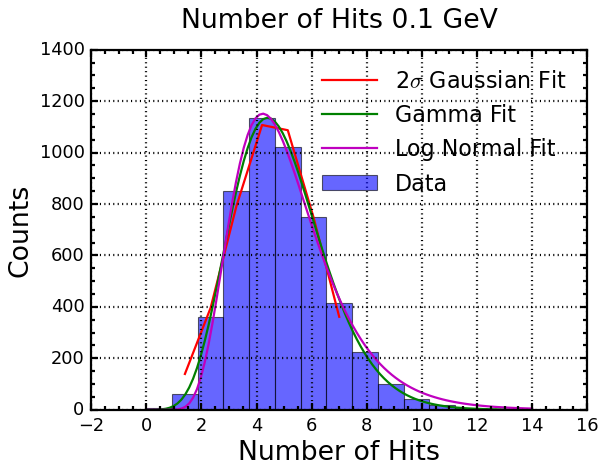

Mean: 11.0498, Peak: 10.5, RMS: 2.8365330881200737
Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(3.8955300913917097), np.float64(0.0), np.float64(2.8365330881200737)]
Gamma Fit Parameters: [ 4.98536071e+03  3.21114092e+01 -4.89663846e+00  4.96195904e-01]
Gamma Fit Peak: 11.036911275064249 ± 0.059482333289275144, Resolution: 0.25476238527896894 ± 0.004269239877824631
Initial Gaussian Fit Parameters: [7.22000000e+02 2.54762385e-01 1.05407154e+01]
Gaussian Fit Peak: 10.740377518432732 ± 0.06401247473360142, Resolution: 0.2537022285052224 ± 0.006578529860254824
Initial Log Normal Fit Parameters: [7.22000000e+02 2.52620017e-01 4.58896502e-01 1.07027840e+01]
Log Normal Fit Parameters: [5.00778692e+03 2.60666662e-01 4.58896502e-04 1.09834804e+01]
Log Normal Fit Peak: 10.262433228985687 ± 0.10402705606411891, Resolution: 0.2651471642626331 ± 0.012951196585321184


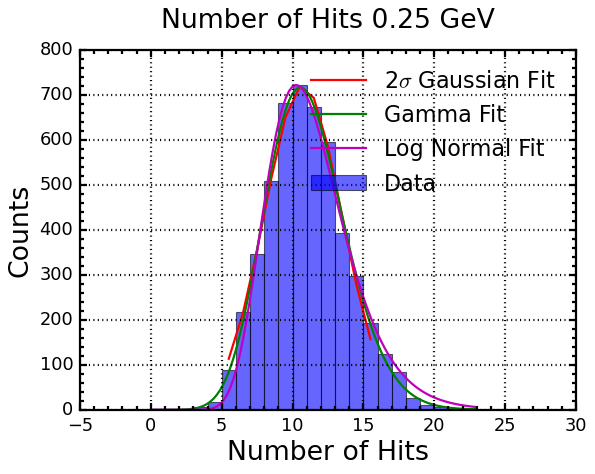

Mean: 19.076, Peak: 18.5, RMS: 3.914718891568078
Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(4.617445211438793), np.float64(1.0), np.float64(3.914718891568078)]
Gamma Fit Parameters: [ 5.00721192e+03  4.61744521e+01 -7.41364955e+00  5.74211835e-01]
Gamma Fit Peak: 19.100267330697104 ± 0.0669046549093896, Resolution: 0.2042836313430133 ± 0.002606523198722306
Initial Gaussian Fit Parameters: [5.32000000e+02 2.04283631e-01 1.85260555e+01]
Gaussian Fit Peak: 18.784969998479124 ± 0.07967872157528265, Resolution: 0.2065514664555508 ± 0.004740467748171847
Initial Log Normal Fit Parameters: [5.32000000e+02 2.03104275e-01 5.68588973e-01 1.86865745e+01]
Log Normal Fit Parameters: [5.02015631e+03 2.07286293e-01 5.68588973e-04 1.90139705e+01]
Log Normal Fit Peak: 18.21485747227684 ± 0.09860895759084805, Resolution: 0.2095268709124708 ± 0.005741061862510988


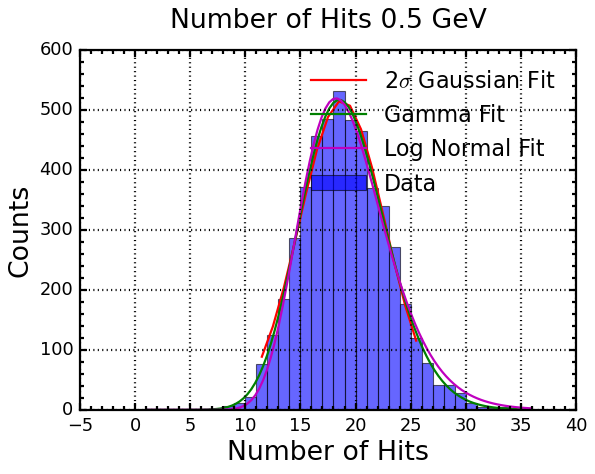

Mean: 32.6096, Peak: 34.5, RMS: 5.3922525756867135
Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(4.192978663860274), np.float64(10.0), np.float64(5.3922525756867135)]
Gamma Fit Parameters: [ 4.99702412e+03  4.19297866e+01 -2.39313091e+00  8.36962587e-01]
Gamma Fit Peak: 32.70053177780271 ± 0.1483672826780885, Resolution: 0.16573436014725504 ± 0.00332233602355126
Initial Gaussian Fit Parameters: [3.98000000e+02 1.65734360e-01 3.18635692e+01]
Gaussian Fit Peak: 32.212827410801644 ± 0.15224681715434324, Resolution: 0.1645628544685736 ± 0.005189628873534491
Initial Log Normal Fit Parameters: [3.98000000e+02 1.64243913e-01 3.18357785e+00 3.21727137e+01]
Log Normal Fit Parameters: [5.00310763e+03 1.66948813e-01 3.18357785e-03 3.25095742e+01]
Log Normal Fit Peak: 31.61916484855737 ± 0.156978879785341, Resolution: 0.1681026575639766 ± 0.004208520872515753


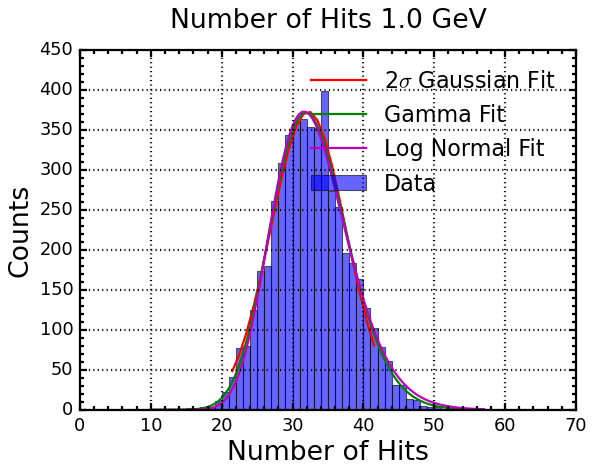

Mean: 55.7614, Peak: 55.5, RMS: 7.113780291799853
Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(3.199620885991849), np.float64(33.0), np.float64(7.113780291799853)]
Gamma Fit Parameters: [4.98503469e+03 3.19962089e+01 1.58434813e+01 1.25631810e+00]
Gamma Fit Peak: 56.0408977913096 ± 0.2013365154302637, Resolution: 0.12680716566737985 ± 0.002630944815182135
Initial Gaussian Fit Parameters: [3.05000000e+02 1.26807166e-01 5.47845797e+01]
Gaussian Fit Peak: 55.359909565975826 ± 0.16968027269528116, Resolution: 0.1255708927415672 ± 0.0033353734718983507
Initial Log Normal Fit Parameters: [3.05000000e+02 1.27060793e-01 1.07273592e+00 5.53130934e+01]
Log Normal Fit Parameters: [4.98475071e+03 1.26733464e-01 1.07273603e-03 5.56360197e+01]
Log Normal Fit Peak: 54.75063953343121 ± 0.19934099284968942, Resolution: 0.1272416152258749 ± 0.002917630386582402


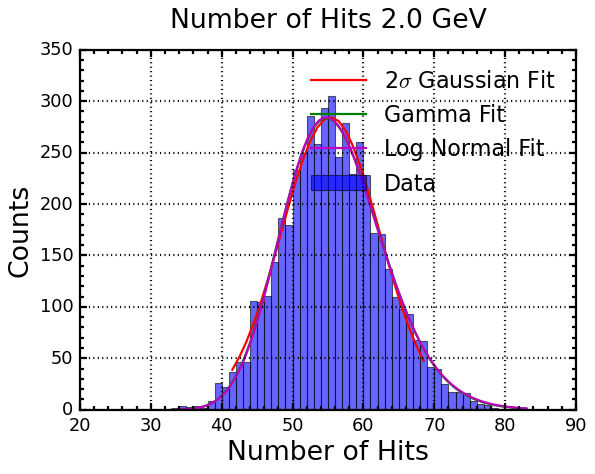

Mean: 112.98238400000001, Peak: 113.47999999999999, RMS: 10.317890051582445
Initial Gamma Fit Parameters: [np.float64(8400.000000000035), np.float64(3.7781352393865952), np.float64(74.0), np.float64(10.317890051582445)]
Gamma Fit Parameters: [8.41536526e+03 3.77813523e+01 4.95334183e+01 1.69984392e+00]
Gamma Fit Peak: 113.75582011376943 ± 0.9983792696132661, Resolution: 0.09184894426020182 ± 0.0062240778260529515
Initial Gaussian Fit Parameters: [4.02000000e+02 9.18489443e-02 1.12055976e+02]
Gaussian Fit Peak: 112.88445619179682 ± 0.8999758994488191, Resolution: 0.09095387795118905 ± 0.008594259188530193
Initial Log Normal Fit Parameters: [4.02000000e+02 9.11334476e-02 1.89641461e+00 1.12514180e+02]
Log Normal Fit Parameters: [8.40271839e+03 9.12689354e-02 1.89683843e-03 1.13144438e+02]
Log Normal Fit Peak: 112.20775447057383 ± 0.9782972515111876, Resolution: 0.09145780679308636 ± 0.006283313062122788


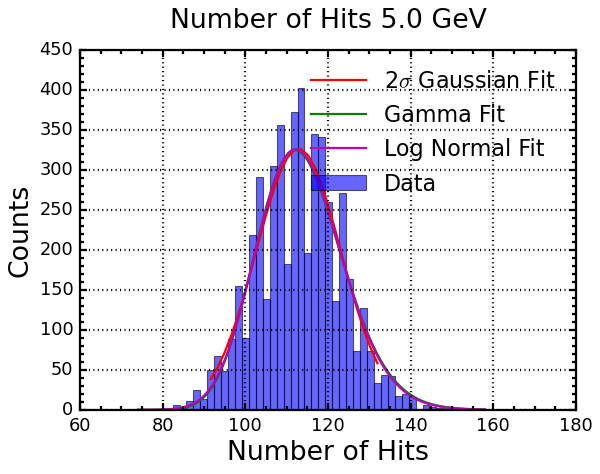

Mean: 190.159296, Peak: 187.07999999999998, RMS: 13.510150713607306
Initial Gamma Fit Parameters: [np.float64(10799.999999999984), np.float64(4.304859156117517), np.float64(132.0), np.float64(13.510150713607306)]
Gamma Fit Parameters: [1.07740342e+04 4.30485916e+01 1.02364596e+02 2.05401300e+00]
Gamma Fit Peak: 190.7869625836787 ± 0.8047947169251757, Resolution: 0.07063727992805245 ± 0.0029328500519701043
Initial Gaussian Fit Parameters: [4.29000000e+02 7.06372799e-02 1.88732950e+02]
Gaussian Fit Peak: 189.72027251636123 ± 0.7338175316142151, Resolution: 0.06975801141382702 ± 0.004169853821182963
Initial Log Normal Fit Parameters: [4.29000000e+02 7.09570817e-02 1.00000000e-01 1.89681181e+02]
Log Normal Fit Parameters: [1.07687792e+04 7.02966694e-02 1.00104296e-04 1.89991655e+02]
Log Normal Fit Peak: 189.05520401122573 ± 0.7902024558510479, Resolution: 0.07038356681449313 ± 0.0029190455149215398


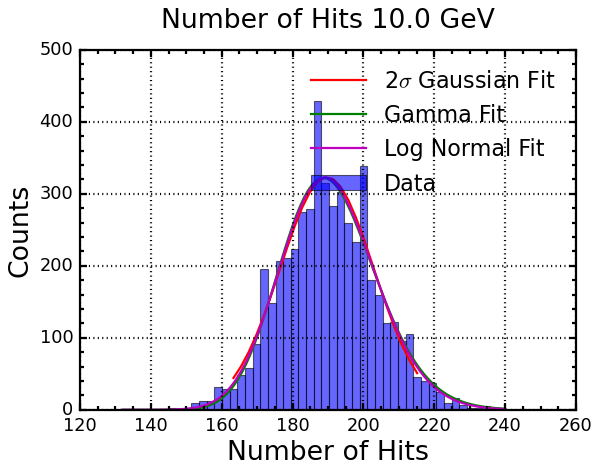

Mean: 311.65428285657134, Peak: 314.15999999999997, RMS: 17.666054314866674
Initial Gamma Fit Parameters: [np.float64(12797.440000000011), np.float64(3.263563092753146), np.float64(254.0), np.float64(17.666054314866674)]
Gamma Fit Parameters: [1.28024133e+04 3.26356309e+01 2.10800122e+02 3.12338547e+00]
Gamma Fit Peak: 312.73377690157275 ± 1.1455720832879677, Resolution: 0.057055406202454674 ± 0.002585367347868653
Initial Gaussian Fit Parameters: [3.64000000e+02 5.70554062e-02 3.09610391e+02]
Gaussian Fit Peak: 311.1565894412102 ± 0.9696687513794167, Resolution: 0.05655325688906666 ± 0.003360166197366115
Initial Log Normal Fit Parameters: [3.64000000e+02 5.66393242e-02 4.00180117e+00 3.11154788e+02]
Log Normal Fit Parameters: [1.27895570e+04 5.64944304e-02 4.00180214e-03 3.11416966e+02]
Log Normal Fit Peak: 310.4286273250262 ± 1.1115242596605621, Resolution: 0.056538812226513656 ± 0.0023711907998846503


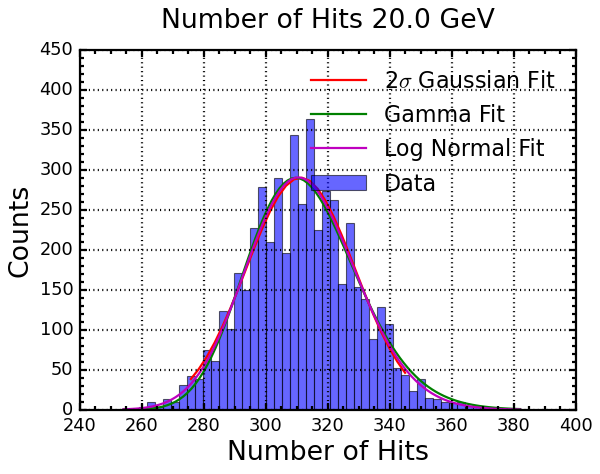

Mean: 413.23702221332803, Peak: 416.6, RMS: 20.869455351736274
Initial Gamma Fit Parameters: [np.float64(17989.200000000114), np.float64(4.7551323472882014), np.float64(314.0), np.float64(20.869455351736274)]
Gamma Fit Parameters: [1.79803791e+04 4.75513235e+01 2.71084301e+02 3.01460174e+00]
Gamma Fit Peak: 414.4326038990624 ± 1.0089138774641646, Resolution: 0.05015997779480515 ± 0.0016669456934377035
Initial Gaussian Fit Parameters: [3.81000000e+02 5.01599778e-02 4.11418002e+02]
Gaussian Fit Peak: 412.857523466823 ± 0.942447218639695, Resolution: 0.04995152621086038 ± 0.00247742747774094
Initial Log Normal Fit Parameters: [3.81000000e+02 5.04702283e-02 4.93888845e+00 4.12711049e+02]
Log Normal Fit Parameters: [1.79622152e+04 4.97908814e-02 4.93889375e-03 4.13174795e+02]
Log Normal Fit Peak: 412.15668772778895 ± 0.9731942717593617, Resolution: 0.0498211620670851 ± 0.0015466816559882594


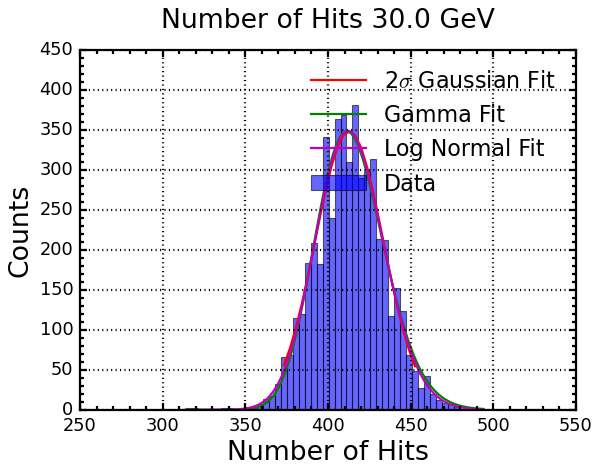

Mean: 502.029663798279, Peak: 497.40999999999997, RMS: 22.504345657475106
Initial Gamma Fit Parameters: [np.float64(19688.17999999999), np.float64(4.844827103962625), np.float64(393.0), np.float64(22.504345657475106)]
Gamma Fit Parameters: [1.95550326e+04 4.84482710e+01 3.50013730e+02 3.15284295e+00]
Gamma Fit Peak: 502.7635202719022 ± 0.4293221127120157, Resolution: 0.04364934403747063 ± 0.000582549948955365
Initial Gaussian Fit Parameters: [3.84000000e+02 4.36493440e-02 4.99610677e+02]
Gaussian Fit Peak: 500.99442343112634 ± 0.4121321144733666, Resolution: 0.04280857538095971 ± 0.0008896657128839909
Initial Log Normal Fit Parameters: [3.84000000e+02 4.48042303e-02 1.00000000e-01 5.01526025e+02]
Log Normal Fit Parameters: [1.95438848e+04 5.41998013e-02 9.99590985e+01 4.01505277e+02]
Log Normal Fit Peak: 500.286636773116 ± 0.41131671113037094, Resolution: 0.043440515697705545 ± 0.000549917055473882


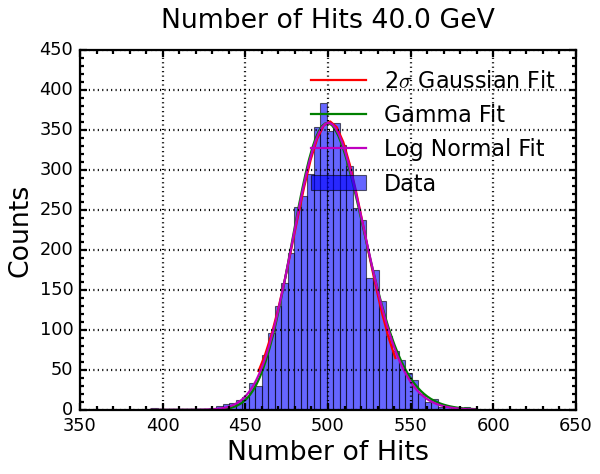

Mean: 583.4589751801441, Peak: 591.98, RMS: 24.982984779513025
Initial Gamma Fit Parameters: [np.float64(21782.560000000067), np.float64(4.981749629940337), np.float64(459.0), np.float64(24.982984779513025)]
Gamma Fit Parameters: [2.16776294e+04 4.98174963e+01 4.12237600e+02 3.47397124e+00]
Gamma Fit Peak: 585.3021494263025 ± 0.8940988464592194, Resolution: 0.041892574240263325 ± 0.0010395578007536673
Initial Gaussian Fit Parameters: [3.88000000e+02 4.18925742e-02 5.81828178e+02]
Gaussian Fit Peak: 583.5042555975095 ± 0.8435779042793576, Resolution: 0.0413617552909145 ± 0.001575840894986149
Initial Log Normal Fit Parameters: [3.88000000e+02 4.27991444e-02 1.01219655e+01 5.82924839e+02]
Log Normal Fit Parameters: [2.16754016e+04 4.16499627e-02 1.01219655e-02 5.83802258e+02]
Log Normal Fit Peak: 582.8005247319368 ± 0.8492257875756941, Resolution: 0.04166731014348098 ± 0.0009370207996056071


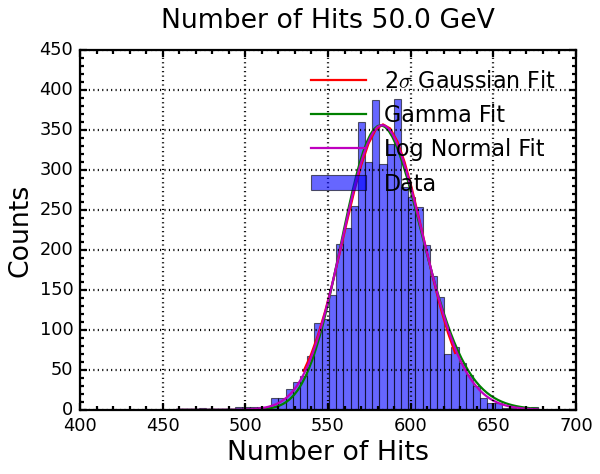

Mean: 657.9097998398718, Peak: 660.62, RMS: 26.719635610945634
Initial Gamma Fit Parameters: [np.float64(26179.040000000045), np.float64(4.899385670747878), np.float64(527.0), np.float64(26.719635610945634)]
Gamma Fit Parameters: [2.59566028e+04 4.89938567e+01 4.79261120e+02 3.69144418e+00]
Gamma Fit Peak: 660.119207335819 ± 0.8982685838984751, Resolution: 0.039142156544799876 ± 0.0009261340756725465
Initial Gaussian Fit Parameters: [4.73000000e+02 3.91421565e-02 6.56427763e+02]
Gaussian Fit Peak: 658.2598547353275 ± 0.8044785708678059, Resolution: 0.03852327368754726 ± 0.0013088242527115835
Initial Log Normal Fit Parameters: [4.73000000e+02 4.05961844e-02 4.33459407e+00 6.57367889e+02]
Log Normal Fit Parameters: [2.59220248e+04 3.87677340e-02 4.33459412e-03 6.58493048e+02]
Log Normal Fit Peak: 657.5084523491349 ± 0.8009595754919736, Resolution: 0.03878204982740951 ± 0.0007889057985870141


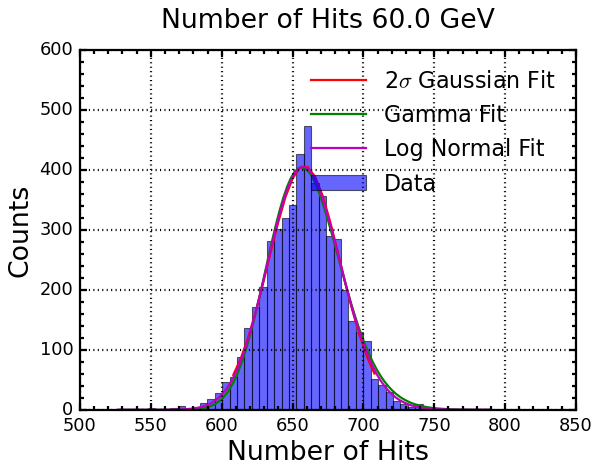

In [6]:
#Fit Number of hits and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    hist = hist_N[i_E]
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(hist['Energy'],"N", hist['bin_edges'], hist['counts'])
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, "NHits_Fit.csv")
df.to_csv(outputfile_name, index=False)

